In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
import cv2
import cv2.cv as cv
import numpy as np
import picar
from math import *
picar.setup()
import numpy as np

bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 8
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(90)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=1.2/210
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [3]:
# Controllers. 
def controller(current_position_pose,waypoint,L,precision,v_min,v_max,k_rho=1,k_alpha=1*5,k_beta=-1*2):
    """controller that takes the current position and desired position, then yields a control signal for v and gamma.
    Automatically round to the max/min speed if exceeding the limits. This is unstable."""
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    v=k_rho*rho*direction
    if v==0:
        return 0,0
    if abs(v)<v_min:
        v=v_min*direction
    if abs(v)>v_max:
        v=v_max*direction
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def controller_cs(current_position_pose,waypoint,L,precision,v_min,k_rho=1.0,k_alpha=1*4.5,k_beta=-1*2.5):
    """controller that takes the current position and desired position, then yields a control signal for v and gamma.
    Keep using constant speed v_min as the speed output. It is stable."""
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    k=v_min/rho
    ratio=k/k_rho
    k_alpha=k_alpha*ratio
    k_beta=k_beta*ratio
    v=v_min*direction
    if v==0:
        return 0,0
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
#     gamma=round(abs(gamma))
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def isclose(a, b, rel_tol=5e-01, abs_tol=0.1):
    """Approximatiy check for two coordinates pair. Determine if the two coordinates are close enough"""
    x,y,_=a
    xg,yg,_=b
    deltad=sqrt((xg-x)**2+(yg-y)**2)
    return abs(deltad-0) <= max(rel_tol * max(abs(deltad), abs(0)), abs_tol)

In [4]:
# load the waypoints
waypoints=[]
with open("waypoints.txt", "r") as filestream:
    for line in filestream:
        currentline = line.rstrip().split(",")
#         print tuple([float(i) for i in currentline])
        waypoints.append(tuple([float(i) for i in currentline]))

In [5]:
# set debug_mode to True if not executing on the car
debug_mode=False

In [6]:
# for manually assignment of initial position_pose
# initial_position_pose=(0.0,0.0,0.0)

initial_position_pose=waypoints[0]
fw.turn(initial_angle_fw)

current_position_pose=initial_position_pose
current_angle_fw=initial_angle_fw
archived_x_y_theta=[]

deltat=0.05
for waypoint in waypoints:
    print 'heading to ' +str(waypoint)
    reached=False
    while not reached:
        x,y,theta=current_position_pose
#         v,gamma=controller(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED,MAX_SPEED)
        v,gamma=controller_cs(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED)
        if v<0:
            direction=-1
        else:
            direction=1
        v=abs(v)
#         count as no turnning
#         if abs(gamma)<3*MIN_RADIAN:
#             gamma=0
        if not debug_mode:
            fw.turn(current_angle_fw-gamma*180/pi)
#         current_angle_fw=current_angle_fw-gamma*180/pi
        motor_speed=int(round(abs(v)/true_speed_unit))
        if not debug_mode:
            bw.speed = motor_speed
        true_speed=motor_speed*true_speed_unit
        if direction==1:
            bw.backward()
        elif direction==-1:
            bw.forward()
        if not debug_mode:
            sleep(deltat)
        bw.stop()
#         if gamma==0:
#             delta_position_pose=(true_speed*cos(theta)*deltat,true_speed*sin(theta)*deltat,0)
#         else:
#             Rb=L/tan(gamma)
#             K=true_speed/Rb
#             delta_position_pose=(Rb*sin(K*deltat),Rb*(1-cos(K*deltat)),K*deltat)
        delta_position_pose=(true_speed*cos(theta)*deltat*direction,true_speed*sin(theta)*deltat*direction,true_speed/L*tan(gamma)*deltat*direction)
        print delta_position_pose
        current_position_pose=tuple(map(sum, zip(current_position_pose, delta_position_pose)))
        archived_x_y_theta.append(current_position_pose)
        print current_position_pose
        if(isclose(current_position_pose,waypoint,abs_tol=deltat*MIN_SPEED) or v==0):
            reached=True
            print str(waypoint)+' reached'
            fw.turn(current_angle_fw)
    if not debug_mode:
        raw_input("Press Enter to continue...")

        

heading to (0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0) reached
Press Enter to continue...s
heading to (1.0, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.020000000000000004, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.04000000000000001, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.06000000000000001, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.08000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.10000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.12000000000000002, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.14, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.16000000000000003, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.18000000000000005, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.20000000000000007, 0.0, 0.0)
0.4 0.0 0.0
(0.020000000000000004, 0.0, 0.0)
(0.22000000000000008, 0.0, 0.0)
0.4 0.0 0.0
(0.02000000000000

(-0.006193772209872071, 0.01901676065506995, 0.018198325622793148)
(1.1517766236457545, 0.463749401472667, 1.9038601778488429)
0.4 0.311447476632 0.108577914164
(-0.006538800715337304, 0.018900901703492998, 0.015572373831592766)
(1.1452378229304172, 0.48265030317616003, 1.9194325516804356)
0.4 0.259759657427 0.0906666207378
(-0.006832327916976061, 0.018796789492754064, 0.012987982871337251)
(1.1384054950134412, 0.5014470926689141, 1.9324205345517729)
0.4 0.208924810716 0.0729937677375
(-0.007075877176576631, 0.018706468458316815, 0.010446240535805468)
(1.1313296178368646, 0.5201535611272309, 1.9428667750875783)
0.4 0.158968979006 0.0555818347652
(-0.007270899821368761, 0.01863153283515932, 0.007948448950291277)
(1.1240587180154957, 0.5387850939623902, 1.9508152240378696)
0.4 0.109921091383 0.038453417522
(-0.007418760370960231, 0.018573152520729216, 0.00549605456912627)
(1.1166399576445354, 0.5573582464831194, 1.9563112786069958)
0.4 0.061811680306 0.0216307138933
(-0.00752072686928498

(0.019689339777641816, -0.003511395608667844, -0.033900999056081724)
(1.356226863081369, 1.1877396137965233, -0.2103855078671707)
0.4 -0.620080208354 -0.21371381731
(0.01955900958238168, -0.004176738459169038, -0.03100401041768174)
(1.3757858726637506, 1.1835628753373542, -0.24138951828485244)
0.4 -0.563012370003 -0.194561586578
(0.019420134902038352, -0.0047810417679238, -0.028150618500157633)
(1.395206007565789, 1.1787818335694304, -0.2695401367850101)
0.4 -0.506783107839 -0.17554827593
(0.01927786908862511, -0.005325764114362613, -0.025339155391931413)
(1.414483876654414, 1.1734560694550678, -0.29487929217694153)
0.4 -0.451373800794 -0.156685875139
(0.01913674459849658, -0.005812487090042623, -0.022568690039709932)
(1.4336206212529108, 1.167643582365025, -0.3174479822166515)
0.4 -0.396778378258 -0.137989878563
(0.019000702111634737, -0.00624286146449842, -0.01983891891292195)
(1.4526213233645455, 1.1614007209005266, -0.33728690112957344)
0.4 -0.343001288163 -0.119478660399
(0.018873

(-0.01919138091958188, 0.005629466972947664, 0.0364798644138283)
(1.9077045532441697, 1.2419206489790546, 2.8927433263650544)
0.4 0.552673221572 0.191075769323
(-0.019383929224102047, 0.004925777891359165, 0.027633661078596262)
(1.8883206240200676, 1.2468464268704138, 2.9203769874436505)
0.4 0.393181719281 0.1367546546
(-0.01951262867837982, 0.004388316540504958, 0.019659085964037898)
(1.8688079953416878, 1.2512347434109188, 2.9400360734076885)
0.4 0.250605738737 0.0874881067735
(-0.01959512291802168, 0.00400389283418295, 0.012530286936828073)
(1.8492128724236663, 1.2552386362451018, 2.9525663603445165)
0.4 -1.57796445756 0.504597798451
(-0.01964375325496982, 0.0037580524288336873, 0.07889822287788645)
(1.8295691191686965, 1.2589966886739354, 3.031464583222403)
0.4 -1.37633809331 0.448915602946
(-0.019878840609159447, 0.0021981119251833813, 0.06881690466574056)
(1.809690278559537, 1.261194800599119, 3.1002814878881435)
0.4 -1.18591949227 0.393431430008
(-0.01998293630285058, 0.00082598

(-0.017841942296096893, 0.00903687418871972, -0.02665059106434712)
(0.871991863449027, 1.2677230182244354, 2.646111088759396)
0.4 0.536233049057 -0.185523344963
(-0.017594796985480735, 0.009509107163120945, -0.02681165245284522)
(0.8543970664635463, 1.2772321253875565, 2.619299436306551)
0.4 0.539394221625 -0.186591894083
(-0.01733354889388103, 0.00997737855067331, -0.02696971108124669)
(0.8370635175696652, 1.2872095039382299, 2.5923297252253046)
0.4 0.542504113302 -0.187642688581
(-0.01705819096755728, 0.010441174307248552, -0.02712520566509055)
(0.820005326602108, 1.2976506782454784, 2.565204519560214)
0.4 0.545570697317 -0.188678439528
(-0.01676873157114475, 0.010899983554799215, -0.0272785348658683)
(0.8032365950309632, 1.3085506618002776, 2.5379259846943456)
0.4 0.548601231839 -0.189701612284
(-0.016465194289292554, 0.011353298067779597, -0.027430061591929313)
(0.7867714007416706, 1.319903959868057, 2.5104959231024164)
0.4 0.551602335864 -0.190714452655
(-0.016147617789385952, 0.0

(0.008278438434859597, 0.018206247748513132, -0.025932515082235028)
(0.566706887436648, 2.153325004248673, 1.1181056228942818)
0.4 -0.514046102862 -0.178011704965
(0.008747735863370116, 0.017985469614794837, -0.025702305143113502)
(0.5754546233000181, 2.171310473863468, 1.0924033177511683)
0.4 -0.509778128505 -0.176564375782
(0.009207063741641318, 0.017754717042446886, -0.02548890642524392)
(0.5846616870416593, 2.189065190905915, 1.0669144113259244)
0.4 -0.505828064461 -0.175224187863
(0.009656572381581444, 0.017514297297901465, -0.025291403223045475)
(0.5943182594232408, 2.2065794882038166, 1.0416230081028788)
0.4 -0.502178931028 -0.173985534957
(0.010096398041345286, 0.017264493812177616, -0.02510894655137895)
(0.6044146574645861, 2.2238439820159943, 1.0165140615514998)
0.4 -0.49881497222 -0.172843202983
(0.01052666322888845, 0.017005568536969527, -0.0249407486109821)
(0.6149413206934745, 2.240849550552964, 0.9915733129405178)
0.4 -0.495721555984 -0.171792339391
(0.01094747703087779,

(0.01989545272563563, -0.0020422930352909543, -0.025905502243918938)
(1.4018454611403925, 2.620169842911286, -0.1281984570280315)
0.4 -0.521048008264 -0.180384513669
(0.019835876519641926, -0.0025569518371526424, -0.026052400413187002)
(1.4216813376600346, 2.6176128910741334, -0.15425085744121853)
0.4 -0.524080678709 -0.181411590962
(0.019762538124456164, -0.0030727978910785286, -0.026204033935460603)
(1.4414438757844907, 2.614540093183055, -0.18045489137667914)
0.4 -0.527209014842 -0.182470662076
(0.01967524303980618, -0.0035895419379857563, -0.026360450742102217)
(1.461119118824297, 2.610950551245069, -0.20681534211878136)
0.4 -0.530434092529 -0.18356205102
(0.019573796549039114, -0.004106883082926106, -0.026521704626466816)
(1.480692915373336, 2.606843668162143, -0.2333370467452482)
0.4 -0.533757105136 -0.184686119371
(0.019458004069058697, -0.0046245083683020055, -0.02668785525681592)
(1.5001509194423945, 2.602219159793841, -0.26002490200206413)
0.4 -0.537179363994 -0.185843266266


(-0.006641604275076438, -0.018865022996362515, -0.08924793162255801)
(1.984839000761147, 1.9272216475870496, -1.9985523455987435)
0.4 -1.70355077581 -0.53765225234
(-0.008296601050497204, -0.018197978212122597, -0.08517753879050485)
(1.9765423997106497, 1.909023669374927, -2.0837298843892484)
0.4 -1.62414209797 -0.516897647899
(-0.009814707778449068, -0.017426173166350995, -0.08120710489870006)
(1.9667276919322005, 1.891597496208576, -2.1649369892879484)
0.4 -1.5463352329 -0.496075282601
(-0.011195937771261122, -0.01657259718396753, -0.07731676164523223)
(1.9555317541609394, 1.8750248990246083, -2.242253750933181)
0.4 -1.4698032783 -0.475125762741
(-0.01244255375469365, -0.015658315875647644, -0.07349016391484094)
(1.9430892004062457, 1.8593665831489607, -2.3157439148480217)
0.4 -1.39428312215 -0.454000873184
(-0.013558665642728921, -0.014702468703883795, -0.06971415610741959)
(1.9295305347635168, 1.844664114445077, -2.3854580709554414)
0.4 -1.31956978985 -0.432664101673
(-0.0145498711

(-0.01541294091229312, -0.012745244306570234, 0.03940198042290467)
(1.0543860340375997, 1.5531132622658728, -2.4112502278511556)
0.4 0.805330171931 0.274737797219
(-0.014898920106682721, -0.013342495255936402, 0.040266508596564526)
(1.039487113930917, 1.5397707670099363, -2.3709837192545913)
0.4 0.822356652777 0.280249825822
(-0.014349732717747891, -0.013931445399856966, 0.041117832638831175)
(1.025137381213169, 1.5258393216100794, -2.32986588661576)
0.4 0.839181700786 0.285679518999
(-0.013764934609080735, -0.014509533941782261, 0.041959085039309604)
(1.0113724466040883, 1.5113297876682972, -2.2879068015764505)
0.4 0.855866395554 0.291046871108
(-0.013144191213279055, -0.0150741579316643, 0.04279331977767653)
(0.9982282553908093, 1.496255629736633, -2.245113481798774)
0.4 0.872470469611 0.296371209084
(-0.012487281384928045, -0.015622669541843019, 0.04362352348055717)
(0.9857409740058812, 1.4806329601947898, -2.201489958318217)
0.4 0.889052552873 0.301671272725
(-0.011794101790455258,

(-0.01970426184436859, -0.0034266696906121935, -0.06415066195609574)
(0.8481731405109959, 0.7407669086133043, -3.0335603066701937)
0.4 -1.17742739462 -0.390893344152
(-0.019883403586007566, -0.0021564465761853687, -0.05887136973079428)
(0.8282897369249883, 0.7386104620371189, -3.092431676400988)
0.4 -1.07322894359 -0.359322998754
(-0.019975836850268276, -0.0009828235505237582, -0.05366144717925384)
(0.80831390007472, 0.7376276384865952, -3.146093123580242)
0.4 -0.970781476616 -0.327535478083
(-0.019999797458040515, 9.00090959641013e-05, -0.04853907383082297)
(0.7883141026166796, 0.7377176475825593, -3.194632197411065)
0.4 -0.870466559469 -0.295729537521
(-0.0199718746623406, 0.0010602935780988263, -0.04352332797345304)
(0.7683422279543389, 0.7387779411606581, -3.238155525384518)
0.4 -0.772664975513 -0.264115128604
(-0.019906828548904715, 0.0019282575358370302, -0.03863324877565867)
(0.7484353994054342, 0.7407061986964951, -3.2767887741601767)
0.4 -0.677739978528 -0.232904313307
(-0.019

(-0.016645240796620674, -0.01108764893124394, 0.03741844470598177)
(-0.11834443937585169, 0.7469228796454196, -2.5165534443127964)
0.4 0.755776368923 0.258598789434
(-0.0162188035528161, -0.011702581395365725, 0.037788818446146864)
(-0.13456324292866778, 0.7352202982500539, -2.4787646258666496)
0.4 0.763151982991 0.261009893747
(-0.01576510326558479, -0.01230697034307989, 0.038157599149567456)
(-0.15032834619425256, 0.7229133279069739, -2.4406070267170823)
0.4 0.770520854528 0.263415696604
(-0.0152841371523197, -0.012899424464257342, 0.038526042726385636)
(-0.16561248334657225, 0.7100139034427166, -2.4020809839906967)
0.4 0.777906734164 0.265823923747
(-0.014775954919053534, -0.013478544291951479, 0.038895336708223614)
(-0.18038843826562578, 0.6965353591507651, -2.363185647282473)
0.4 0.785332185666 0.268241874275
(-0.014240659104004972, -0.014042920931327654, 0.03926660928331191)
(-0.19462909736963074, 0.6824924382194375, -2.323919037999161)
0.4 0.79281875456 0.270676476938
(-0.013678

Press Enter to continue...d


In [373]:
bw.stop()
fw.turn(initial_angle_fw)

34

<IPython.core.display.Javascript object>


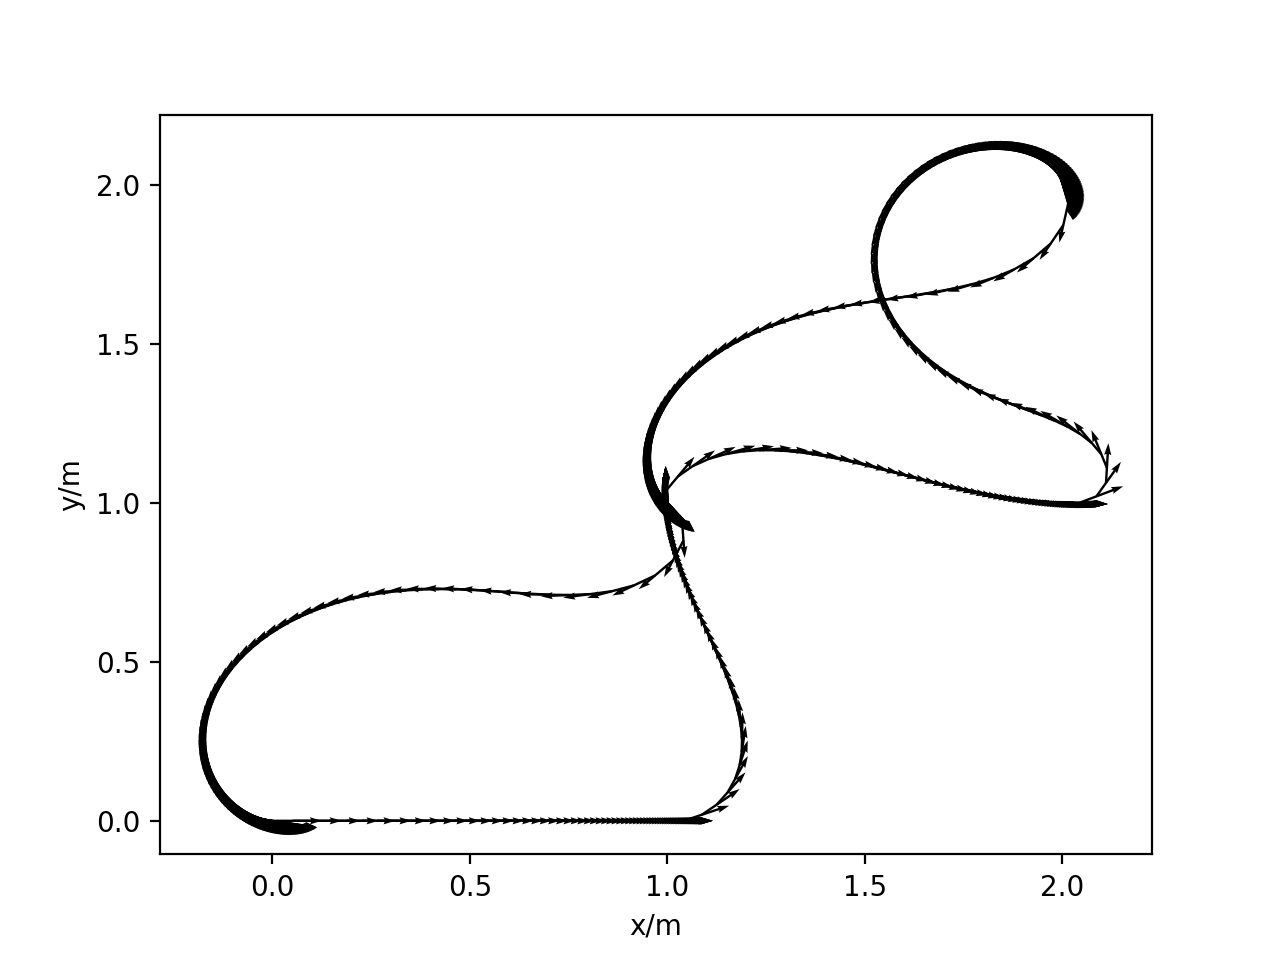

In [16]:
# Visualization
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()

ax.quiver(ptdata[:,0],ptdata[:,1],np.cos(ptdata[:,2]),np.sin(ptdata[:,2]),
          angles='xy', scale_units='xy', scale=8)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
# fig.savefig('ideal_traj.pdf', bbox_inches='tight')


<IPython.core.display.Javascript object>


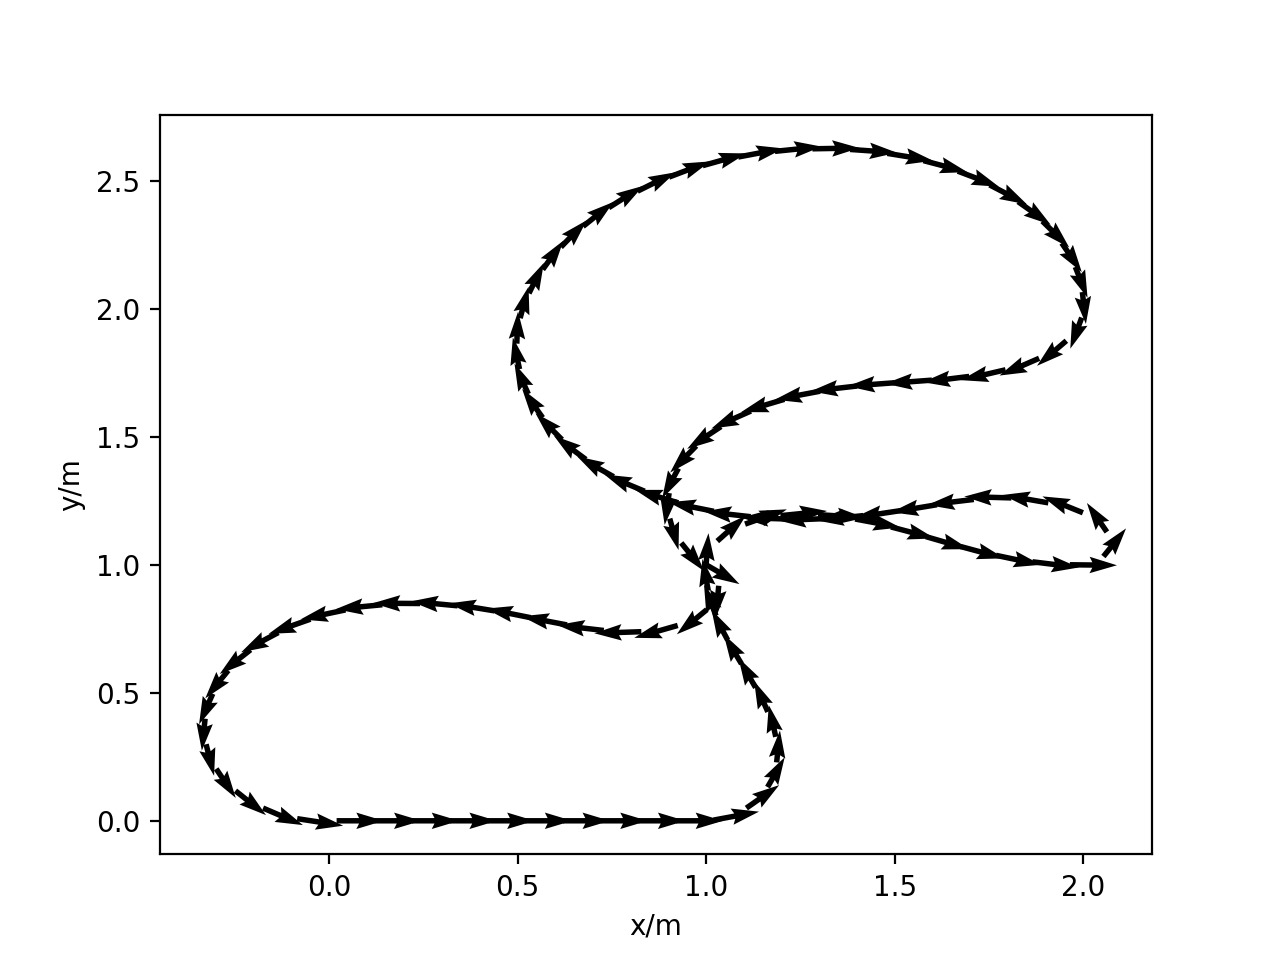

In [15]:
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()
sample=5
ax.quiver(ptdata[:,0][1::sample],ptdata[:,1][1::sample],np.cos(ptdata[:,2][1::sample]),np.sin(ptdata[:,2][1::sample]),
          angles='xy', scale_units='xy', scale=8)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
fig.savefig('acutal_used.pdf', bbox_inches='tight')